## Classifying Iris Notebook

Please make sure you have **matplotlib** installed in the compute context you choose as kernel. 

- For local or remote **Docker kernels**, please ensure **notebook** and **matplotlib** are listed in your **conda_dependencies.yml** file under **aml_config** folder.
```
name: project_environment
dependencies:
  - python=3.5.2
  - scikit-learn
  - pip:
      - notebook
      - matplotlib
```

In [8]:
%matplotlib inline
%azureml history off

History logging disabled


In [20]:
import pickle
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets
from sklearn import preprocessing

from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve

from azureml.logging import get_azureml_logger
from azureml.dataprep import package

In [10]:
logger = get_azureml_logger()
print ('Python version: {}'.format(sys.version))
print ()

Python version: 3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:52:12) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]



In [11]:
%azureml history on

History logging enabled


In [12]:
#load Iris dataset from a DataPrep package
iris = package.run('iris.dprep', dataflow_idx=0, spark=False)

# load features and labels
X, Y = iris[['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']].values, iris['Species'].values

# tag this cell to measure duration
logger.log("Cell","Load Data")
logger.log("Rows",iris.shape[0])

print ('Iris dataset shape: {}'.format(iris.shape))

Iris dataset shape: (150, 5)


In [13]:
logger.log("Cell", "Training")

# change regularization rate and you will likely get a different accuracy.
reg = 0.01

print("Regularization rate is {}".format(reg))
logger.log('Regularization Rate', reg)

# train a logistic regression model
clf = LogisticRegression(C=1/reg).fit(X, Y)
print (clf)

# Log curves for label value 'Iris-versicolor'
y_scores = clf.predict_proba(X)
precision, recall, thresholds = precision_recall_curve(Y, y_scores[:,1],pos_label='Iris-versicolor')
logger.log("Precision",precision)
logger.log("Recall",recall)
logger.log("Thresholds",thresholds)

accuracy = clf.score(X, Y)
logger.log('Accuracy', accuracy)
print ("Accuracy is {}".format(accuracy))

Regularization rate is 0.01
LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy is 0.98


In [15]:
logger.log("Cell", "Scoring")

# predict a new sample
X_new = [[3.0, 3.6, 1.3, 0.25]]
print ('New sample: {}'.format(X_new))
pred = clf.predict(X_new)
logger.log('Prediction', pred.tolist())

print('Predicted class is {}'.format(pred))

New sample: [[3.0, 3.6, 1.3, 0.25]]
Predicted class is ['Iris-setosa']


In [18]:
%azureml history off

History logging disabled


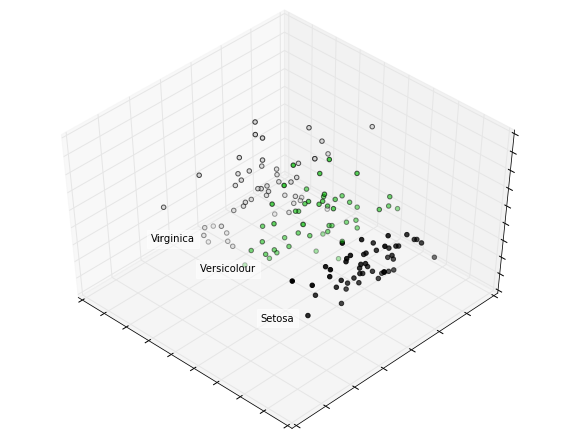

In [21]:
# Plot Iris data in 3D
centers = [[1, 1], [-1, -1], [1, -1]]

fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# decompose 4 feature columns into 3 components for 3D plotting
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

le = preprocessing.LabelEncoder()
le.fit(Y)
Y = le.transform(Y)

for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
    ax.text3D(X[Y == label, 0].mean(),
              X[Y == label, 1].mean() + 1.5,
              X[Y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
y = np.choose(Y, [1, 2, 0]).astype(np.float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=Y, cmap=plt.cm.spectral)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()